# Fitting a model to data using **zeus**

In [16]:
import zeus
import numpy as np 
import matplotlib.pyplot as plt

print('zeus version:', zeus.__version__)

zeus version: 2.3.0


## The generative model

Lets define a sinusoidal model with Gaussian uncorrelated measurement errors.

$$ y = A \sin \Bigg[ 2\pi \Big(\frac{t}{P}+t_{0}\Big)\Bigg] + B + \epsilon$$

where $\epsilon \sim \mathcal{N}(0,\sigma^{2})$.

In [10]:
def sine_model(params, t):
    A, B, P, t0 = params
    return A * np.sin((t / P + t0) * 2 * np.pi) + B

We can now use the model to generate some synthetic data/observations. To this end we first need to define the time instances in which we "took" our measurements as well as how many such measurements we obtained.

In [124]:
np.random.seed(42)

# Number of data points
n_data = 50

# time of observations
t = np.random.uniform(0, 5, size=n_data)

Our next step is to decide what are the "true" values of the parameters and generate the data assuming a measurement error (standard deviation) of $\sigma = 1.0$.

In [125]:
# A=4.3, B=1.0, P=3.1, t=0.4
params_true = [4.3, 1.0, 3.1, 0.4]

yerr = 1.0
y = np.random.normal(sine_model(params_true, t), yerr)

Now we can plot the data.

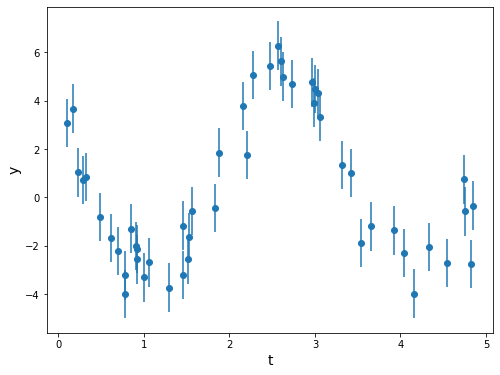

In [157]:
plt.figure(figsize=(8,6))
plt.errorbar(x=t, y=y, yerr=yerr, marker='o', ls=' ')
plt.xlabel('t', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.show()

## Prior, Likelihood and Posterior

Given some data $D$ and a model $\mathcal{M}$ with parameters $\theta$ we define the posterior distribution $\mathcal{P}(\theta)\equiv P(\theta | D, \mathcal{M})$ using Bayes's rule:

$$\mathcal{P}(\theta) = \frac{\mathcal{L}(\theta) \pi (\theta)}{\mathcal{Z}}$$

where $\mathcal{L}(\theta) \equiv P(D|\theta, \mathcal{M})$ is the likelihood function, $\pi (\theta) \equiv P (\theta | \mathcal{M})$ is the prior distribution of the model parameters $\theta$, and $\mathcal{Z}\equiv P(D|\mathcal{M})$ is the, so called, Bayesian model evidence or marginal likelihood.


Starting with the prior we can assume independend flat (uniform) priors such that

$$ \pi (\theta) \equiv P(A,B,P,t_{0}) = P (A) P (B) \pi (P) P (t_{0}) $$

and

$$
P(\theta) = 
\begin{cases}
    1/(\theta_{max}-\theta_{min}) & \text{if } \theta_{min} <\theta <\theta_{max} \\
    0 & \text{otherwise}
\end{cases}
$$
for $\theta \in \lbrace A, B, P, t_{0} \rbrace$.

In [161]:
def log_prior(params):
    A, B, P, t0 = params
    # A -> [0.1, 100.0]
    # B -> [-10.0, 10.0]
    # P -> [0.3, 10.0]
    # t0 -> [0.0, 1.0]

    if np.abs(B)>10.0 or A<0.1 or A>100.0 or P<0.3 or P>10.0 or t0<0.0 or t0>1.0:
        return -np.inf
        
    return 0.0

As for the likelihood function we assume that the errors are Gaussian and independend. This means the likelihood function is Gaussian (i.e. the distribution is Normal).

$$
\log \mathcal{L}(\theta) \equiv \log P(D|A,B,P,t_{0}) = -\frac{1}{2}\sum_{n}\Bigg[ \frac{\big(\mathcal{M}(A,B,P,t_{0})-D\big)^{2}}{\sigma^{2}} +\log\big(2\pi\sigma^{2}\big)\Bigg]
$$

In [128]:
def log_like(params):
    # compute for each t point, where it should lie in y
    y_model = sine_model(params, t)
    # compute likelihood
    loglike = -0.5 * (((y_model - y) / yerr)**2).sum()

    return loglike

It's very simple to combine the two

$$\log \mathcal{P}(\theta) \propto \log \mathcal{L}(\theta) + \log \pi (\theta)$$

In [129]:
def log_post(params):
    lp = log_prior(params)
    if ~np.isfinite(lp):
        return -np.inf 
    return lp + log_like(params)

## Maximum a Posteriori (MAP) estimate

We can maximise the log-posterior (or equivalently minimize the negative log-posterior) in order to find the MAP estimate. To do this we will use the scipy.optimize.minimize function.

In [177]:
from scipy.optimize import minimize

# Initial guess
p_guess = [10.0, 2.0, 4.0, 0.5]


# Run the minimisation procedure using the Nelder-Mead method
results = minimize(lambda x : -log_post(x), p0, method='Nelder-Mead', options={'maxiter':2000, 'disp':True})

print('MAP =', results.x)

Optimization terminated successfully.
         Current function value: 20.540879
         Iterations: 76
         Function evaluations: 123
MAP = [4.21923235 0.98576703 3.10960913 0.39962441]


## Markov Chain Monte Carlo with **zeus**

Before we run the MCMC we first need to initialise the walkers. We choose to place them close to the MAP estimate. The number of walkers needs to be at least twice the number of parameters.

In [164]:
ndim = 4 
nwalkers = 10
nsteps = 1000

start = results.x + 0.001 * np.random.randn(nwalkers, ndim)

We can now initialise the sampler and run the MCMC.

In [165]:
sampler = zeus.EnsembleSampler(nwalkers, ndim, log_post)

sampler.run_mcmc(start, nsteps)

Initialising ensemble of 10 walkers...
Sampling progress : 100%|██████████| 1000/1000 [00:02<00:00, 396.13it/s]


## Results

We can access the results using the ".get_chain()" method.

In [178]:
samples = sampler.get_chain()
print(samples.shape)

(1000, 10, 4)


It's good practice to plot the walker trajectories/chains and inspect them to be sure that they have mixed sufficiently.

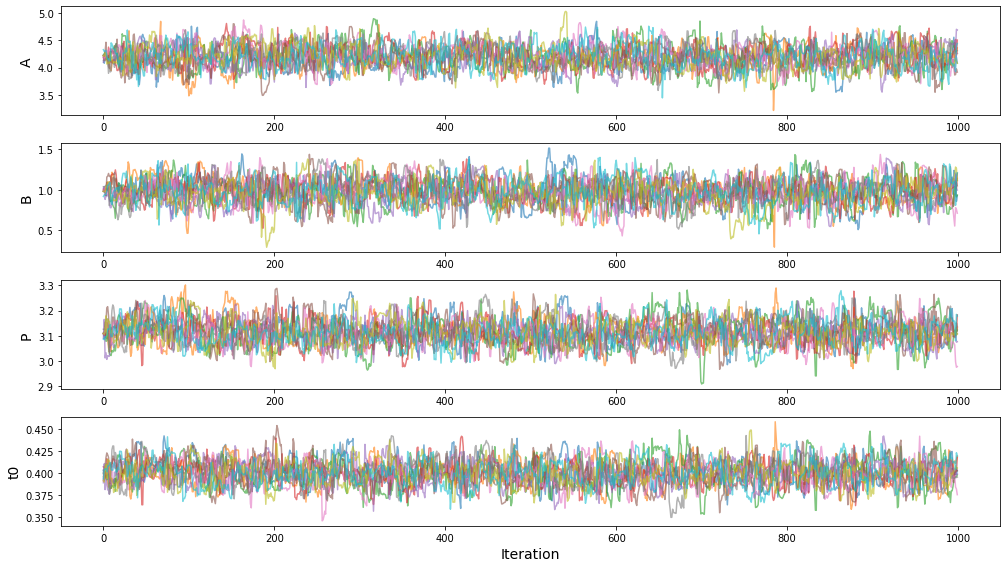

In [167]:
labels = ['A', 'B', 'P', 't0']

plt.figure(figsize=(14,8))
for i in range(ndim):
    plt.subplot(ndim,1,i+1)
    plt.plot(samples[:,:,i],alpha=0.6)
    plt.ylabel(labels[i], fontsize=14)
plt.xlabel('Iteration', fontsize=14)
plt.tight_layout()
plt.show()

We can discard the first half of the chain to make sure that the chain has converged, flatten the walker trajectories into a single one, thin the result, and visualise the 1-D and 2-D marginal posteriors.

/Users/minas/anaconda3/envs/nbodykit-env/lib/python3.7/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'linewidth'
  **contour_kws,
/Users/minas/anaconda3/envs/nbodykit-env/lib/python3.7/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'linewidth'
  **contour_kws,
/Users/minas/anaconda3/envs/nbodykit-env/lib/python3.7/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'linewidth'
  **contour_kws,
/Users/minas/anaconda3/envs/nbodykit-env/lib/python3.7/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'linewidth'
  **contour_kws,
/Users/minas/anaconda3/envs/nbodykit-env/lib/python3.7/site-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'linewidth'
  **contour_kws,
/Users/minas/anaconda3/envs/nbodykit-env/lib/python3.7/

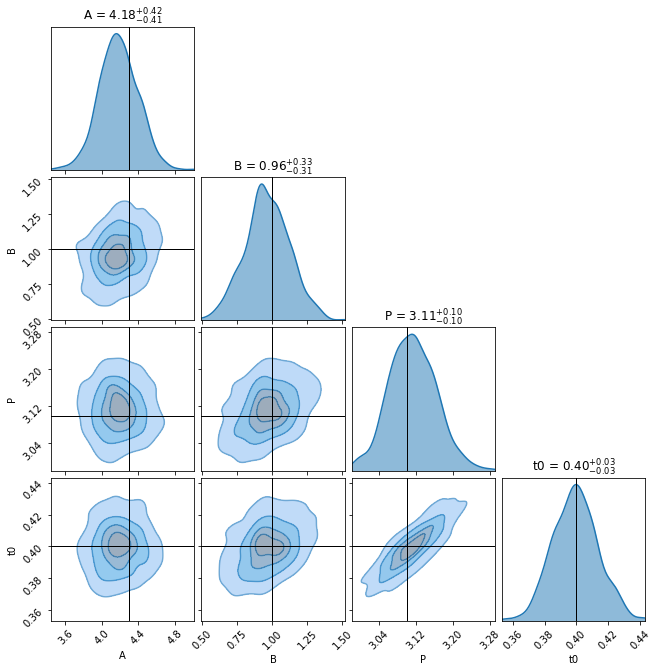

In [168]:
chain = sampler.get_chain(flat=True, discard=0.5, thin=7)

zeus.cornerplot(chain, labels=labels, truth=params_true);

Using the chains we can compute all sorts of statistics.

In [176]:
print('mean =', np.mean(chain,axis=0))
print('standard deviation =', np.std(chain,axis=0))

mean = [4.18499716 0.96412273 3.11308314 0.39953573]
standard deviation = [0.21192107 0.15855334 0.05018975 0.01414885]


## Posterior Predictive Checks

Finally, we can perform some Posterior Predictive Checks to make sure that eveything is as it should be.

The distribution that reflects the probability of new data given the current data is the *posterior predictive distribution*:

$$
P(D_{new}|D) = \int_{\Theta} P(D_{new}|\theta,D)P(\theta|D)d\theta
$$
where $P(D_{new}|\theta,D) = P(D_{new}|\theta)$ assuming $D_{new}$ is independent of $D$.

The easiest way to sample from the posterior predictive distribution is to use the chains that we have already to generate the new data.

In [169]:
t_range = np.linspace(0.0, 5.0, 1000)

obs = []

for s in chain:
    m = sine_model(s, t_range)
    obs.append(np.random.normal(m, yerr))

obs = np.array(obs)

Finally, we can plot the $95\%$ intervals.

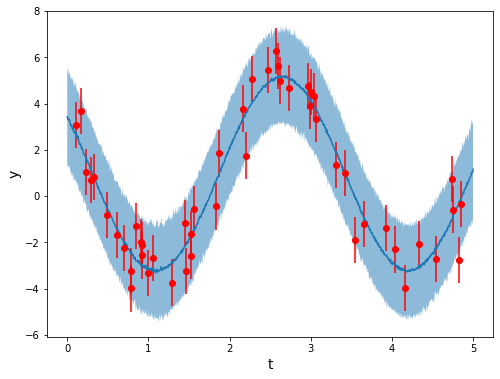

In [180]:
plt.figure(figsize=(8,6))
plt.fill_between(t_range, np.percentile(obs,2.5,axis=0),np.percentile(obs,97.5,axis=0),alpha=0.5)
plt.plot(t_range, np.mean(obs, axis=0))
plt.errorbar(x=t, y=y, yerr=yerr, marker='o', ls=' ', color='red')
plt.xlabel('t', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.show()